<a href="https://colab.research.google.com/github/RERobbins/data_science_266_sandbox/blob/main/Embeddings_and_Vector_Databases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## OpenAI and Cohere Accounts and API Endpoints

OpenAI and Cohere provide large language models.  This notebook uses API endpoints from each.  

OpenAI provides free, rate-limited usage to its API endpoint for a three-month trial period.  In order to use the OpenAI API endpoint you will need an OpenAI API token.

Cohere provides free, rate-limited usage for learning and prototyping. In order to use Cohere you will need a Cohere API token.

If you don't already have an OpenAI API token you can get one by signing up for a free OpenAI account from the [OpenAI Signup page](https://platform.openai.com/signup?launch).  Once you have created your OpenAI account you can create a trial API key from the [OpenAI API page](https://platform.openai.com/account/api-keys).

If you don't already have a Cohere API token you can get one by signing up for a Cohere account from the [Cohere dashboard](https://dashboard.cohere.ai).  Once you have created your Cohere account you can create a trial API key from the [Cohere API Keys page](https://dashboard.cohere.ai/api-keys).

## Mount Google Drive

By default, the data you create in Google Colaboratory does not persist from session to session.  Each session runs in a virtual machine and when that machine goes away, so does your data.  If you want your data to persist, you must store it outside the virtual machine. Google Drive can be used for that purpose.  We use it later in this notebook to store the OpenAI and Cohere API keys.

In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


## Python-dotenv

`Python-dotenv` is a Python module that allows you to specify environment variables in traditional UNIX-like “.env” (dot-env) file within your Python project directory.

Environment variables are key-value pairs for the current user environment. They are generally set by the operating system and the current user-specific configurations.

`Python-dotenv` allows the user to work with API keys without exposing them to the outside world.

In [2]:
!pip install --quiet python-dotenv

## Add API Keys to .env File

The format of a .env file is simple: each line contains a single key-value pair, with the key and value separated by an equal sign (=). Here's an example:
```
DATABASE_URL=your_database_url
API_KEY=your_api_key
DEBUG=True
```
To use OpenAI and Cohere, we need to set the `OPENAI_API_KEY` and `COHERE_API_KEY` environment variables, which means the `.env` file should have lines that looks like:
```
OPENAI_API_KEY=your_openai_api_key_value
COHERE_API_KEY=your_cohere_api_key_value
```
One way to do that is to create or edit the `.env` file directly.  As with most Unix systems, file names that begin with a `.` in Google Drive are hidden from display, but you can still access them. For example, if you enter the name `.env` in the Google Drive search bar, you will be able to access your `.env` file (if it exists).

You can use the `append_key_to_env` helper function included below.  If used without arguments it will prompt the user for the value of an OpenAI API key and then the value of a Cohere API key and append each with the correct key name to the `.env` file in the root of the users Google Drive folder.  It will create the `.env` file if necessary.  You can provide an alternate list of key names and an alternate path to the function if you desire, but the defaults are fine for this notebook.

Once the OpenAI and Cohere APIs key have been stored in the `.env` file you should not need to do anything else with that file.  If either of your keys change you will need to update the `.env` file.

In [3]:
def append_key_to_env (env_file_path = '/content/drive/MyDrive/.env',
                           key_names = ['OPENAI_API_KEY', 'COHERE_API_KEY']):
  import getpass
  with open(env_file_path, 'a') as env_file:
    for key_name in key_names:
      key_value = getpass.getpass (f"Please enter the value for {key_name}: ")
      env_file.write(f'{key_name}={key_value}\n')

In [4]:
# Remove the # character in the line below and run if desired
# append_key_to_env()

## Load the API Keys

The following cell loads the OpenAI and Cohere API keys into the current environment.

In [5]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv('/content/drive/MyDrive/.env')
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
COHERE_API_KEY = os.environ["COHERE_API_KEY"]

# Langchain

LangChain is a framework designed to simplify the creation of applications using large language models. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

The examples in this notebook use LangChain rather than the underlying Python modules.  A description of LangChain is beyond the scope of this notebook.

In [6]:
!pip install --quiet langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.6 MB/s eta 0:00:00


# Embeddings

We will use OpenAI and Cohere large language models and embeddings, calculate cosine similarity and look at some heatmaps.

An overview of OpenAI models can be found [here](https://platform.openai.com/docs/models/overview) and an overciew of OpenAI embeddings can be found [here](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings).

An overview of Cohere models and embeddings can be found [here](https://docs.cohere.com/docs/models).

In [7]:
!pip install --quiet openai cohere tiktoken

import openai
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings.cohere import CohereEmbeddings

import cohere
from langchain.chat_models import ChatOpenAI
from langchain.llms import Cohere

from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.8 MB/s eta 0:00:00


In [8]:
def openai_token_count (text):
  embedding_model = OpenAIEmbeddings()
  openai_encoding = tiktoken.encoding_for_model(embedding_model.model)
  return len(openai_encoding.encode (text))

def cohere_token_count (text, model_name="command"):
  co = cohere.Client(COHERE_API_KEY)
  return len(co.tokenize(text=text, model=model_name))

def embeddings_similarity_heatmap(embeddings, figsize=None):
  if figsize is None:
    figsize = (len(embeddings), len(embeddings))
  similarity_matrix = cosine_similarity(embeddings)
  plt.figure(figsize=figsize)
  sns.heatmap(cosine_similarity (embeddings), cmap='viridis', annot=True, fmt=".3f")

Instantiate the embededing models.  

The default OpenAI model is `text-embedding-ada-002`, which is the preferred OpenAI embedding model for its GPT 3.5 and GPT 4 models.  
The maximum number of tokens for the OpenAI embedding model is 8192.

The default Cohere model is `embed-english-v2.0`  
The maximum number of tokens for the Cohere embedding model is `512`.

In [9]:
openai_embeddings_model = OpenAIEmbeddings ()
openai_embeddings_model.model

'text-embedding-ada-002'

In [10]:
cohere_embeddings_model = CohereEmbeddings(truncate='None')
cohere_embeddings_model.model

'embed-english-v2.0'

## Short Strings

Let's create OpenAI and Cohere embeddings from a series of strings, calculate pairwise cosine similarity and look at some heatmaps of the results.

Which embedding model do you think performs better on these strings?

In [11]:
strings = ["That movie was great.",
           "That film was wonderful.",
           "That movie was awesome.",
           "That film was rotten.",
           "That show was garbage.",
           "Grab a snapshot of the trash",
           "Take a picture of that rubbish.",
           "Film the garbage."]

openai_embeddings = openai_embeddings_model.embed_documents(strings)
cohere_embeddings = cohere_embeddings_model.embed_documents(strings)

In [12]:
[openai_token_count(string) for string in strings]

[5, 5, 5, 5, 5, 6, 7, 4]

In [13]:
[cohere_token_count(string) for string in strings]

[5, 5, 5, 5, 5, 6, 7, 4]

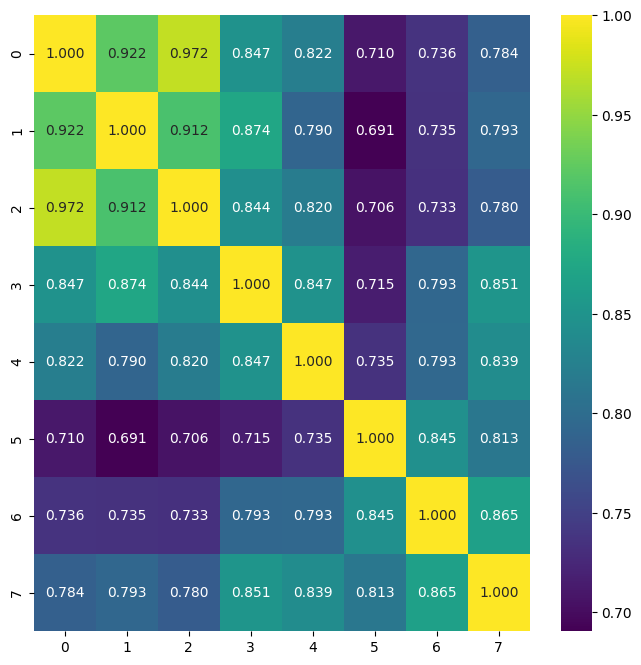

In [14]:
embeddings_similarity_heatmap (openai_embeddings)

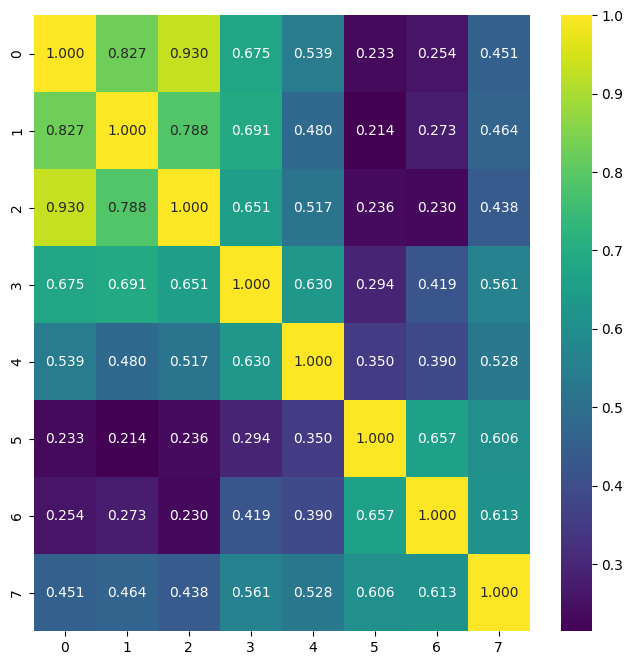

In [15]:
embeddings_similarity_heatmap (cohere_embeddings)

## Multilingual

We use embeddings to capture semantic similarity.  What happens when we look at the same text in several languages.  Will our embeddings reflect the semantic similarity?

Let's examine "Mary had a little lamb" in English, French and Spanish.

In [16]:
mary_english = """Mary had a little lamb,
Little lamb, little lamb,
Mary had a little lamb,
Its fleece was white as snow

Everywhere that Mary went,
Mary went, Mary went,
Everywhere that Mary went
The lamb was sure to go.

It followed her to school one day
School one day, school one day
It followed her to school one day
Which was against the rules.

It made the children laugh and play,
Laugh and play, laugh and play,
It made the children laugh and play
To see the lamb at school

And so the teacher turned it out,
Turned it out, turned it out,
And so the teacher turned it out,
But still it lingered near
"""

mary_french = """Mary avait un petit agneau,
Un petit agneau, un petit agneau,
Mary avait un petit agneau,
C'est toison était blanche comme neige, ouais

Partout, les Mary est allé,
Mary est allé, Mary est allé
Partout, les Mary est allé
Le petit agneau était sûr d'aller, ouais

Il la suivit à l'école un jour
A l'école un jour, à l'école un jour
Il la suivit à l'école un jour
Et enfreint la règle des enseignants.

Il a fait les enfants rient et jouent,
Rire et jouer, rire et jouer,
Il a fait les enfants rient et jouent
Pour voir un agneau à l'école

Et si l'enseignant il s'est avéré,
Il s'est avéré, il s'est avéré,
Et si l'enseignant il s'est avéré,
Mais toujours il resta près de
"""

mary_spanish = """Mary tenía un pequeño cordero,
Pequeño cordero, pequeño cordero
Mary tenía un pequeño cordero
Su lana era blanca como la nieve como la nieve blanca.

A cualquier lado que Mary iba
Mary iba, Mary iba
A cualquier lado que Mary iba
El cordero atrás yendo iba

Un día a la escuela la siguió
A la escuela un día, a la escuela un día
Un día a la escuela la siguió
Y eso estaba en contra de las reglas de la misma.

Hizó a los niños reír y jugar,
Reír y jugar, reír y jugar
Hizó a los niños reír y jugar
De verlo en la escuela estar.

Y entonces la maestra lo alejó,
Lo alejó, lo alejó
Y entonces la maestra lo alejó
Pero sin embargo cerca permanecía.
"""

mary = [mary_english, mary_french, mary_spanish]
mary_openai_embeddings = openai_embeddings_model.embed_documents(mary)
mary_cohere_embeddings = cohere_embeddings_model.embed_documents(mary)

In [17]:
[openai_token_count(string) for string in mary]

[143, 212, 218]

In [18]:
[cohere_token_count(string) for string in mary]

[160, 284, 260]

The OpenAI embeddings for the three renditions are similar.

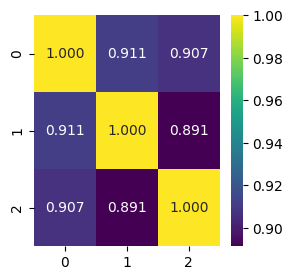

In [19]:
embeddings_similarity_heatmap (mary_openai_embeddings)

The Cohere embeddings are not similar.

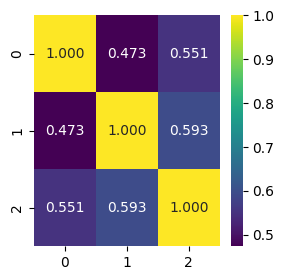

In [20]:
embeddings_similarity_heatmap (mary_cohere_embeddings)

Cohere has a separate embedding model that provides multilingual embedding suport.  Unlike the `embed-english-v2.0` model which has a 512 token maximum, the `embed-multilingual-v2.0` model has a 256 token maximum.  See [Cohere multilingual language models](https://docs.cohere.com/docs/multilingual-language-models)

The default Cohere embedding model is, by intent, English only.  The Cohere multilingual model is much stronger on this example.

Consider how the OpenAI embedding model compares to the Cohere multilingual embedding model.

In [21]:
cohere_multilingual_embeddings_model = CohereEmbeddings(model="embed-multilingual-v2.0", truncate='None')
cohere_multilingual_embeddings_model

CohereEmbeddings(client=<cohere.client.Client object at 0x7a33e8264400>, async_client=<cohere.client_async.AsyncClient object at 0x7a33e8265330>, model='embed-multilingual-v2.0', truncate='None', cohere_api_key=None)

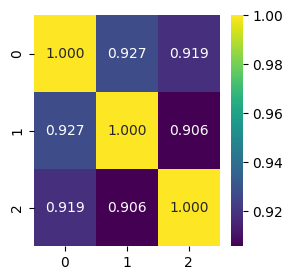

In [22]:
mary_cohere_multilingual_embeddings = cohere_multilingual_embeddings_model.embed_documents(mary)
embeddings_similarity_heatmap (mary_cohere_multilingual_embeddings)

Let's add "Three Blind Mice", in English and compare the OpenAI and Cohere multilingual embeddings

In [23]:
mice = """Three blind mice, three blind mice
See how they run, see how they run
They all run away from the farmer's wife
Then into a space ship to take a ride
Did you ever see such a sight in your life
As three blind mice?

Three blind mice, three blind mice
Crash on the moon, crash on the moon
The moon was covered in cheese so high
And nobody knew the reason why
Did you ever see such a sight in your life
As three blind mice?

Three blind mice, three blind mice
With full tummies, with full tummies
All of them ate too much cheese that night
With little moon left after every bite
Did you ever see such a sight in your life
As three blind mice?"""

In [24]:
openai_token_count(mice)

159

In [25]:
cohere_token_count(mice)

160

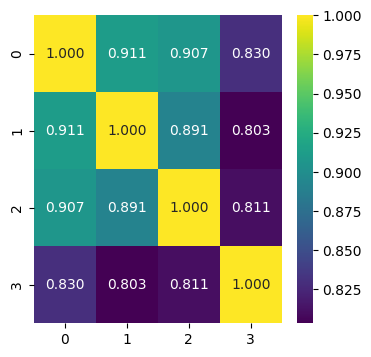

In [26]:
mary_mice_openai_embeddings = openai_embeddings_model.embed_documents(mary + [mice])
embeddings_similarity_heatmap (mary_mice_openai_embeddings)

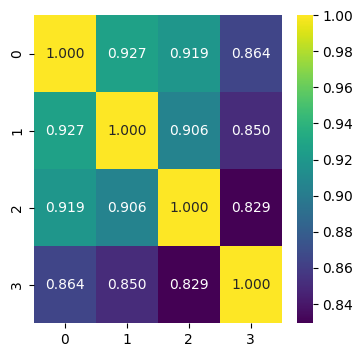

In [27]:
mary_mice_cohere_multilingual_embeddings = cohere_multilingual_embeddings_model.embed_documents(mary + [mice])
embeddings_similarity_heatmap (mary_mice_cohere_multilingual_embeddings)

What happens when we add some music lyrics to the mix.

In [28]:
bohemian = """I see a little silhouetto of a man
Scaramouche, Scaramouche, will you do the Fandango?
Thunderbolt and lightning, very, very frightening me
(Galileo) Galileo, (Galileo) Galileo, Galileo Figaro, magnifico
But I'm just a poor boy, nobody loves me
He's just a poor boy from a poor family
Spare him his life from this monstrosity"""

In [29]:
openai_token_count(bohemian)

97

In [30]:
cohere_token_count(bohemian)

92

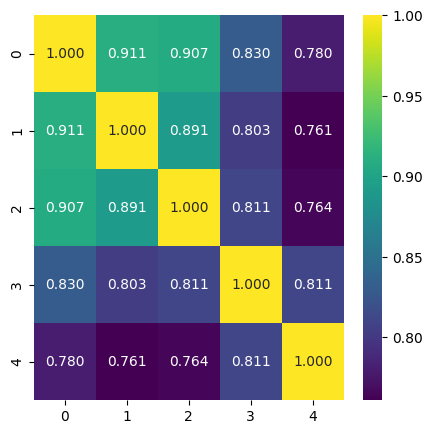

In [31]:
amalgam_openai_embeddings = openai_embeddings_model.embed_documents(mary + [mice, bohemian])
embeddings_similarity_heatmap (amalgam_openai_embeddings)

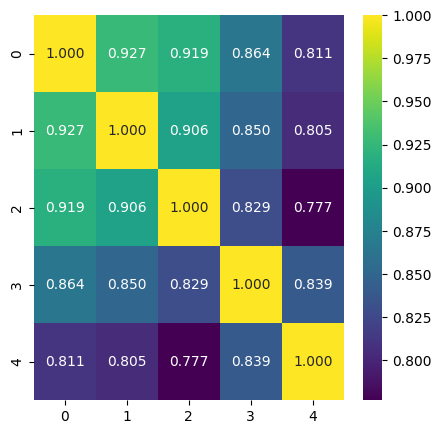

In [32]:
amalgam_cohere_multilingual_embeddings = cohere_multilingual_embeddings_model.embed_documents(mary + [mice, bohemian])
embeddings_similarity_heatmap (amalgam_cohere_multilingual_embeddings)

# Vector Databases

## Introduction

A vector database, also known as a vector search engine or similarity search database, is a type of database that specializes in storing and retrieving high-dimensional vectors efficiently.  The embeddings we have been using are high-dimensional vectors.

In the context of question answering tasks, vector databases can be particularly useful for tasks like semantic search, where you want to find documents or data points that are semantically similar to a given query.

Traditional relational databases are not well-suited for efficiently querying and retrieving semantically similar data. Vector databases, on the other hand, are designed to handle similarity-based searches efficiently.

Vector databases are an essential component of modern natural language processing solutions that are built to apply the generative capabilities of large language models to data collections.  This approach is called retrieval augmented generation or "RAG".

RAG is used in tasks like question answering.  With RAG, a retrieval component first selects a set of relevant documents or passages from a larger corpus, and then a generation component generates the final response based on the selected information. This approach aims to combine the accuracy of retrieval with the flexibility of generation.

We will use Chroma, a simple vector database and explore some of the most important concepts.


In [33]:
!pip install --quiet chromadb
from langchain.vectorstores import Chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━

## Document Chunking

Document chunking, also known as text segmentation or document splitting, refers to the process of breaking down large documents or pieces of text into smaller, manageable segments before feeding them to large language models. There are several reasons why chunking is important when working with these models.

Chunking documents when working with large language models is essential to overcome input limitations, improve performance, manage costs, ensure complete responses, maintain contextual coherence, and guide the model's attention effectively. It allows you to make the most out of these powerful models when dealing with lengthy or complex text documents.

In the following code cells, we will download several corporate privay policies from the web.  We will use document loaders specific to `pdf` files or `urls` as the case may be.

We the use LangChain's `RecursiveCharacterTextSplitter` to chunk each document.  See the relevant [LangChain documentation](https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/recursive_text_splitter).

We add a piece of metadata that identifies the relevant organization for each chunk.  We discuss this in greater detail below.

In [34]:
!pip install --quiet pypdf unstructured

import textwrap
from langchain.document_loaders import PyPDFLoader, UnstructuredURLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.3/270.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 2.1 MB/s eta 0:00:00


In [35]:
Apple_Privacy_Policy = "https://www.apple.com/legal/privacy/pdfs/apple-privacy-policy-en-ww.pdf"
Google_Privacy_Policy = "https://static.googleusercontent.com/media/www.google.com/en//intl/en/policies/privacy/google_privacy_policy_en.pdf"
Meta_Privacy_Policy = "https://about.fb.com/wp-content/uploads/2022/07/Privacy-Within-Metas-Integrity-Systems.pdf"
TikTok_Privacy_Policy = "https://www.tiktok.com/legal/page/us/privacy-policy/en"
Threads_Privacy_Policy = "https://terms.threads.com/privacy-policy"


In [36]:
def get_chunks (path, organization, chunk_size=1500, chunk_overlap=150):

    """
    This function takes a url to an organization's web page and returns
    embeddings constructed from the target url.  The function adds the
    organization name as metadata to the embeddings.

    Parameters:
    path (string): Target page.
    organization (string): Organization name.
    chunk_size (int, optional): Chunk size, default is 1500 characters.
    chunk_overlap (int, optional): Chunk overlap, default is 150 characters.

    Returns:
    list of chunks
    """

    # Use PyPDFLoader for pdf targets, otherwise UnstructuredURLLoader
    if os.path.splitext(path)[1] == ".pdf":
      loader = PyPDFLoader(path)
    else:
      loader = UnstructuredURLLoader(urls=[path])

    # Load the documents and add organization metadata field.
    # Increment page count metadata by one so it's not zero-based.

    documents = loader.load()
    for document in documents:
      metadata = document.metadata
      metadata['organization'] = organization
      if metadata.get('page', None) is not None:
        metadata['page'] += 1

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size,
                                                   chunk_overlap=chunk_overlap)

    return text_splitter.split_documents(documents)

def explore_documents (documents):
  block_indent = "   "
  print(f"{len(documents)} chunks")
  print("First chunk:")
  print(f" Metadata: {documents[0].metadata}\n Contents:")
  print(textwrap.fill(documents[0].page_content,
                      initial_indent=block_indent,
                      subsequent_indent=block_indent,
                      replace_whitespace=True))

In [37]:
chunks = get_chunks(Apple_Privacy_Policy, "Apple")
explore_documents(chunks)

24 chunks
First chunk:
 Metadata: {'source': '/tmp/tmpjyu5ky8v/tmp.pdf', 'page': 1, 'organization': 'Apple'}
 Contents:
   Apple Privacy Policy Apple’s Privacy Policy describes how Apple
   collects, uses, and shares your personal data. Updated December 22,
   2022  In addition to this Privacy Policy, we provide data and
   privacy information embedded in our products and certain features
   that ask to use your personal data. This product-specific
   information is accompanied by our Data & Privacy Icon.  You will be
   given an opportunity to review this product-specific information
   before using these features. You also can view this information at
   any time, either in Settings related to those features and/or
   online at apple.com/legal/privacy/data.  You can familiarize
   yourself with our privacy practices, accessible via the headings
   below, and contact us if you have questions. Apple Health Study
   Apps Privacy Policy


In [38]:
chunks = get_chunks(Google_Privacy_Policy, "Google")
explore_documents(chunks)

22 chunks
First chunk:
 Metadata: {'source': '/tmp/tmp5f5387sx/tmp.pdf', 'page': 1, 'organization': 'Google'}
 Contents:
   Privacy Policy Last modified: December 18, 2017 ( view archived
   versions ) (The hyperlinked examples are available at the end of
   this document.) There are many different ways you can use our
   services – to search for and share information, to communicate with
   other people or to create new content. When you share information
   with us, for example by creating a Google Account , we can make
   those services even better – to show you more relevant search
   results  and ads, to help you connect with people  or to make
   sharing with others quicker and easier . As you use our services,
   we want you to be clear how we’re using information and the ways in
   which you can protect your privacy. Our Privacy Policy explains:
   What information we collect and why we collect it.  How we use that
   information.  The choices we offer, including how to access 

In [39]:
chunks = get_chunks(Meta_Privacy_Policy, "Meta")
explore_documents(chunks)

50 chunks
First chunk:
 Metadata: {'source': '/tmp/tmpwc2r3lbv/tmp.pdf', 'page': 1, 'organization': 'Meta'}
 Contents:
   July 2022   Privacy within Meta’s   Integrity Systems   Why user
   rights are at the center   of our safety and security approach


In [40]:
chunks = get_chunks(TikTok_Privacy_Policy, "TikTok")
explore_documents(chunks)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


24 chunks
First chunk:
 Metadata: {'source': 'https://www.tiktok.com/legal/page/us/privacy-policy/en', 'organization': 'TikTok'}
 Contents:
   How TikTok is supporting our community through COVID-19  U.S.
   Privacy Policy  Last updated: May 22, 2023  This Privacy Policy
   applies to TikTok services (the “Platform”), which include TikTok
   apps, websites, software and related services accessed via any
   platform or device that link to this Privacy Policy. The Platform
   is provided and controlled by TikTok Inc. (“TikTok”, “we” or “us”).
   We are committed to protecting and respecting your privacy. This
   Privacy Policy explains how we collect, use, share, and otherwise
   process the personal information of users and other individuals age
   13 and over in connection with our Platform. For information about
   how we collect, use, share, and otherwise process the personal
   information of users under age 13 (“Children”), please refer to our
   Children’s Privacy Policy.  Capital

In [41]:
chunks = get_chunks(Threads_Privacy_Policy, "Threads")
explore_documents(chunks)

17 chunks
First chunk:
 Metadata: {'source': 'https://terms.threads.com/privacy-policy', 'organization': 'Threads'}
 Contents:
   🤝Legal  Privacy Policy  Effective date: April 17, 2023  At Threads,
   we take your privacy seriously. Please read this Privacy Policy to
   learn how we treat your personal data. By using or accessing
   Threads in any manner, you acknowledge that you accept the
   practices and policies outlined below, and you hereby consent that
   we will collect, use and share your information as described in
   this Privacy Policy.  Remember that your use of Threads is at all
   times subject to our Terms of Use, which incorporates this Privacy
   Policy. Any terms we use in this Policy without defining them have
   the definitions given to them in the Terms of Use.  You may access
   this Privacy Policy in an alternative format by contacting
   privacy@threads.com.  As we continually work to improve Threads, we
   may need to change this Privacy Policy from time to ti

## Create Vector Database from Chunked Documents

We will use the `get_chunks` helper function we used above to assemble a list of all the chunks and then pass that list to a function that instantiates a vector database from those chunks and an embedding model.

In [42]:
# Iterate over the organization names to build up a single list of chunks.

chunks = []
organizations = ["Apple", "Google", "Meta", "TikTok", "Threads"]

for organization in organizations:
  policy_url = locals()[f"{organization}_Privacy_Policy"]
  policy_chunks = get_chunks(policy_url, organization)
  print (f"{organization}'s privacy policy yielded {len(policy_chunks)} chunks.")
  chunks += policy_chunks

Apple's privacy policy yielded 24 chunks.
Google's privacy policy yielded 22 chunks.
Meta's privacy policy yielded 50 chunks.
TikTok's privacy policy yielded 24 chunks.
Threads's privacy policy yielded 17 chunks.


In [43]:
# There are 137 chunks in all.

len(chunks)

137

In [44]:
# Let's take a look at a couple of chunks.

chunks[22]

Document(page_content='Our Companywide Commitment to Your\xa0Privacy To make sure your personal data is secure, we communicate our privacy and security guidelines to Apple employees and strictly enforce privacy safeguards within the company. Privacy Questions If you have questions about Apple’s Privacy Policy or privacy practices including where a third-party service provider is acting on our behalf, or you would like to contact our Data Protection Officer, you can contact us at apple.com/legal/privacy/contact or call the Apple Support number for your country or region. You can also ask us questions about how to submit a privacy complaint and we will endeavor to help.  Apple takes your privacy questions seriously. A dedicated team reviews your inquiry to determine how best to respond to your question or concern, including those inquiries received in response to an access or download request. In most cases, all substantive contacts receive a response within seven days. In other cases, w

In [45]:
chunks[128]

Document(page_content='You can learn more about our use of Cookies on our\xa0Cookie Policy.\n\nData Security\n\nWe seek to protect your Personal Data from unauthorized access, use and disclosure using appropriate physical, technical, organizational and administrative security measures based on the type of Personal Data and how we are processing that data. You should also help protect your data by appropriately selecting and protecting your password and/or other sign-on mechanism; limiting access to your computer or device and browser; and signing off after you have finished accessing your account. Although we work to protect the security of your account and other data that we hold in our records, please be aware that no method of transmitting data over the internet or storing data is completely secure.\n\nData Retention', metadata={'source': 'https://terms.threads.com/privacy-policy', 'organization': 'Threads'})

In [46]:
LLM_SOURCE="Cohere"  #set this to either "OpenAI" or "Cohere"

if LLM_SOURCE=="OpenAI":
  embeddings_model=openai_embeddings_model
else:
  embeddings_model=cohere_embeddings_model

vectordb = Chroma.from_documents(documents=chunks, embedding=embeddings_model)

In [47]:
assert vectordb._collection.count() == len(chunks)

## Query the Vector Database

A similarity search that returns the four vectors closest to the query by default.

In [48]:
query = "Does Apple sell my personal data?"
results = vectordb.similarity_search(query)
[result.metadata for result in results]

[{'organization': 'Apple', 'page': 6, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 4, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 5, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 2, 'source': '/tmp/tmpz4atblk3/tmp.pdf'}]

Examine the first result in the list.  It looks to be responsive to the question.

In [49]:
print(textwrap.fill(results[0].page_content))

Apple’s Sharing of Personal Data Apple may share personal data with
Apple-affiliated companies, service providers who act on our behalf,
our partners, developers, and publishers, or others at your direction.
Apple does not share personal data with third parties for their own
marketing purposes.  •Service Providers. Apple may engage third
parties to act as our service providers and perform certain tasks on
our behalf, such as processing or storing data, including personal
data, in connection with your use of our services and delivering
products to customers. Apple service providers are obligated to handle
personal data consistent with this Privacy Policy and according to our
instructions. •Partners. At times, Apple may partner with third
parties to provide services or other offerings. For example, Apple
financial offerings like Apple Card and Apple Cash are offered by
Apple and our partners. Apple requires its partners to protect your
personal data. •Developers and Publishers from Whom 

Increase the number of results to 10.

In [50]:
query = "Does Apple sell my personal data?"
results = vectordb.similarity_search(query, k=10)
[result.metadata for result in results]

[{'organization': 'Apple', 'page': 6, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 4, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 5, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 2, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 3, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 4, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 4, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 1, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 2, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 2, 'source': '/tmp/tmpz4atblk3/tmp.pdf'}]

When we ask about Apple's use of cookies, there's a problem.  We get responses that don't relate to Apple.

Can you imagine why?

In [51]:
query = "Does Apple use cookies?"
results = vectordb.similarity_search (query, k=10)
[result.metadata for result in results]

[{'organization': 'Apple', 'page': 7, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 7, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 5, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 4, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 8, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 2, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 8, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Google', 'page': 7, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'TikTok',
  'source': 'https://www.tiktok.com/legal/page/us/privacy-policy/en'},
 {'organization': 'Apple', 'page': 2, 'source': '/tmp/tmpz4atblk3/tmp.pdf'}]

The first result looks good.  It talks about Apple and the fact that Apple uses cookies.

In [52]:
print(textwrap.fill(results[0].page_content))

In addition to cookies, Apple uses other technologies that help us
achieve similar objectives.  In some email messages Apple sends to
you, we provide a “click-through URL” that links you to content on the
Apple website. When you click one of these URLs, they pass through a
separate server before arriving at the destination page on our
website. We track this click-through to help us determine interest in
particular topics and measure whether we are communicating with you
effectively. If you prefer not to be tracked in this way, you should
not click graphic or text links in email messages.


Now lets look at any other responses.  Did we ask for too many results?  Are there chunks that talk about cookies but don't mention the company?

In [53]:
for result in results:
  if result.metadata['organization'] != "Apple":
    print(textwrap.fill(result.page_content))
    print(result.metadata)
    print()

We allow trusted businesses to use cookies or similar technologies for
advertising and research purposes on our services. Learn more. "phone
number" For example, if you add a phone number as a recovery option,
if you forget your password Google can send you a text message with a
code to enable you to reset it. Learn more. "protect Google and our
users" For example, if you're concerned about unauthorized access to
your email, "Last account activity" in Gmail shows you information
about recent activity in your email, such as the IP addresses that
accessed your mail, the associated location, as well as the time and
date. Learn more. "protect" For example, one reason we collect and
analyze IP addresses and cookies is to protect our services against
automated abuse. Learn more. "provide" For example, the IP address
assigned to your device is used to send the data you requested back to
your device. Learn more.
{'organization': 'Google', 'page': 7, 'source': '/tmp/tmpawgho1vl/tmp.pdf'}

Cooki

When we processed the source documents and split them into chunks, we added the name of the organization for the policy as metadata.  We can use that metadata as a filter.  In our example below, the filter is very simple, we merely indicate that the organization field needs to be `Apple`.  When we add that parameter, the results are limited to Apple embeddings.

In [54]:
results = vectordb.similarity_search (query, filter = {'organization':'Apple'}, k=10)
[result.metadata for result in results]

[{'organization': 'Apple', 'page': 7, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 7, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 5, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 4, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 8, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 2, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 8, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 2, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 6, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Apple', 'page': 4, 'source': '/tmp/tmpz4atblk3/tmp.pdf'}]

Our next query only references "the company" and not any specific company.  The results relate to several of the companies.

In [55]:
query = "Does the company sell private data?"
results = vectordb.similarity_search (query, k=10)
[result.metadata for result in results]

[{'organization': 'Threads',
  'source': 'https://terms.threads.com/privacy-policy'},
 {'organization': 'Google', 'page': 7, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'Threads',
  'source': 'https://terms.threads.com/privacy-policy'},
 {'organization': 'TikTok',
  'source': 'https://www.tiktok.com/legal/page/us/privacy-policy/en'},
 {'organization': 'Google', 'page': 3, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'TikTok',
  'source': 'https://www.tiktok.com/legal/page/us/privacy-policy/en'},
 {'organization': 'Apple', 'page': 4, 'source': '/tmp/tmpz4atblk3/tmp.pdf'},
 {'organization': 'Google', 'page': 4, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'TikTok',
  'source': 'https://www.tiktok.com/legal/page/us/privacy-policy/en'},
 {'organization': 'Apple', 'page': 6, 'source': '/tmp/tmpz4atblk3/tmp.pdf'}]

We can use the filter to indicate that we care about Google only.

In [56]:
query = "Does the company sell private data?"
results = vectordb.similarity_search (query, filter = {'organization':'Google'}, k=10)
[result.metadata for result in results]

[{'organization': 'Google', 'page': 7, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'Google', 'page': 3, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'Google', 'page': 4, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'Google', 'page': 4, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'Google', 'page': 9, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'Google', 'page': 1, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'Google', 'page': 3, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'Google', 'page': 2, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'Google', 'page': 5, 'source': '/tmp/tmpawgho1vl/tmp.pdf'},
 {'organization': 'Google', 'page': 6, 'source': '/tmp/tmpawgho1vl/tmp.pdf'}]

In [57]:
print(textwrap.fill(results[5].page_content))

Privacy Policy Last modified: December 18, 2017 ( view archived
versions ) (The hyperlinked examples are available at the end of this
document.) There are many different ways you can use our services – to
search for and share information, to communicate with other people or
to create new content. When you share information with us, for example
by creating a Google Account , we can make those services even better
– to show you more relevant search results  and ads, to help you
connect with people  or to make sharing with others quicker and easier
. As you use our services, we want you to be clear how we’re using
information and the ways in which you can protect your privacy. Our
Privacy Policy explains:  What information we collect and why we
collect it.  How we use that information.  The choices we offer,
including how to access and update information. We’ve tried to keep it
as simple as possible, but if you’re not familiar with terms like
cookies, IP addresses, pixel tags and browsers

# Answering Questions With Retrieval Augmented Generation

Now that we have some familiarity with vector databases, lets use ours, together with a large language model, to answer questions about the five privacy policies we have been working with.  We will continue to rely on the LangChain framework and use Cohere.

In [58]:
!pip install --quiet transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00


In [59]:
if LLM_SOURCE=="OpenAI":
  llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
  # llm = ChatOpenAI(model="gpt-4", temperature=0)

else:
  llm = Cohere(model="command", temperature=0)

## Prompting a Model

[reword] Before we introduce working with the vector database, let's experiment with a simple model prompt.  We will pass a string to Cohere's `command` model, which is its default generative model, and see how it responds.

The responses are based on information the model was trained on.  We don't know if it they are accurate.  Sources are not presented.  The response for Threads doesn't seem to relate to the Threads social media platform either.

In [60]:
### Add this section back -- or not.

## LangChain PromptTemplate

A prompt template is a reproducible way to generate prompts. It's essentially a text string that can take in a set of parameters from the end user and generate a prompt accordingly.  Let's shift to LangChain chains by using the simplest of templates.

The responses are not the same as before.  The substance of each has shifted too.

Remember, the model is generating responses based on its training data.

In [61]:
from langchain import PromptTemplate, LLMChain

In [62]:
template = """Question: {question} Answer:"""
prompt = PromptTemplate(
    template=template,
    input_variables=['question']
)

chain = LLMChain(prompt=prompt, llm=llm)

In [63]:
query = "Does Apple sell my personal data?"
print(textwrap.fill(chain.run(query)).strip())

Apple does not sell your personal data. However, it does collect and
use data in ways that may be considered a sale under certain laws. For
example, Apple may share your data with third parties for marketing
purposes, or it may use your data to improve its products and
services. In these cases, Apple may be considered to have sold your
data even though it does not receive any direct financial
compensation.


In [64]:
query = "Does Threads sell my personal data?"
print(textwrap.fill(chain.run(query)).strip())

Threads does not sell your personal data. Threads is a social media
platform that allows users to share their personal experiences and
connect with others. Threads does not share or sell user data to third
parties.


## LangChain RetrievalQA Chain

Now we introduced our vector database and the LangChain Retrieval QA chain, a chain for question answering against a database of information.  This time, the response for Apple mentions the privacy policy.  It would be reassuring if sources were identified.

In [65]:
from langchain.chains import RetrievalQA

chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
    )

In [66]:
query = "Does Apple sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

No, Apple does not sell your personal data. Apple's privacy policy
specifically states that they do not share personal data with third
parties for their own marketing purposes. However, it is important to
note that Apple may share personal data with Apple-affiliated
companies, service providers, partners, developers, and publishers, or
others at your direction. This means that your personal data may be
shared with these parties for legitimate business purposes, such as to
provide services or products, fulfill orders, process payments, or for
research and development purposes. Additionally, Apple may use your
personal data to improve their offerings, for internal purposes such
as auditing or data analysis, or for troubleshooting.


In [67]:
query = "Does Threads sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

I don't know.


We can build our own prompt to be used in the QA chain.  Our prompt will be based on the PromptTemplate we looked at above.

In [68]:
template = """Use the following pieces of context to answer the question at the end.
Your answer should be as concise as possible and not more than three sentences.
If you don't know the answer, just say that you don't know.

{context}

Question: {question}

Answer:"""

prompt = PromptTemplate(template=template,
                        input_variables=["context", "question"]
                        )

chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type_kwargs={"prompt": prompt}
)

In [69]:
query = "Does Apple sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

Apple does not share personal data with third parties for their own
marketing purposes, however, they may share data with Apple-affiliated
companies, service providers, partners, developers, and publishers.
They may also use your data for research and development purposes.


In [70]:
query = "Does Threads sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

Threads may share your personal data with third parties in certain
circumstances, such as with vendors or service providers who are
necessary to provide you with Threads. However, Threads does not sell
your personal data to third parties.


Get source documents.

In [71]:
chain = RetrievalQA.from_chain_type(llm=llm,
                                 chain_type="stuff",
                                 retriever=vectordb.as_retriever(search_type="mmr", search_kwargs={'fetch_k': 30}), \
                                 return_source_documents=True)

In [72]:
query = "Does Apple sell my personal data?"
result = chain({"query": query})

In [73]:
result['source_documents']

[Document(page_content='Apple’s Sharing of Personal Data Apple may share personal data with Apple-affiliated companies, service providers who act on our behalf, our partners, developers, and publishers, or others at your direction. Apple does not share personal data with third parties for their own marketing purposes.  •Service Providers. Apple may engage third parties to act as our service providers and perform certain tasks on our behalf, such as processing or storing data, including personal data, in connection with your use of our services and delivering products to customers. Apple service providers are obligated to handle personal data consistent with this Privacy Policy and according to our instructions. •Partners. At times, Apple may partner with third parties to provide services or other offerings. For example, Apple financial offerings like Apple Card and Apple Cash are offered by Apple and our partners. Apple requires its partners to protect your personal data. •Developers a